# Resorting to Ensembles of Learners

In [1]:
import numpy as np
import pandas as pd

In [2]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style='whitegrid', palette='deep', font='sans-serif')
except:
    import matplotlib.pyplot as plt

In [3]:
filename = 'https://github.com/lmassaron/datasets/'
filename += 'releases/download/1.0/wine_quality.feather'
wine = pd.read_feather(filename)

In [4]:
train = (wine.groupby('quality')
             .apply(lambda x: x.sample(frac=.8))
             .reset_index(drop=True))

test = wine[~wine.index.isin(train.index)]

X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

## Effect of more trees on a Random Forest

In [29]:
from sklearn.metrics import make_scorer

mae = make_scorer(mean_absolute_error, greater_is_better=False)
# 'neg_mean_squared_error'

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor

series = [10, 25, 50, 100, 150, 200, 250, 300, 500]
rf = RandomForestRegressor(random_state=101)
train_scores, test_scores = validation_curve(rf, 
              X_train, y_train, 
              'n_estimators', param_range=series,
              cv=5, scoring=mae, n_jobs=-1)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)
plt.plot(series, test_scores.mean(axis=1), '-o')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error')
plt.show()

## Understanding the importance measures

In [18]:
from sklearn.inspection import permutation_importance

In [19]:
rf = RandomForestRegressor(random_state=101)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

In [20]:
from sklearn.metrics import mean_absolute_error

preds = rf.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"RF mean absolute error: {mae:0.3}")

RF mean absolute error: 0.185


In [21]:
result = permutation_importance(rf, X_test, 
   y_test, n_repeats=30, random_state=42, n_jobs=-1)

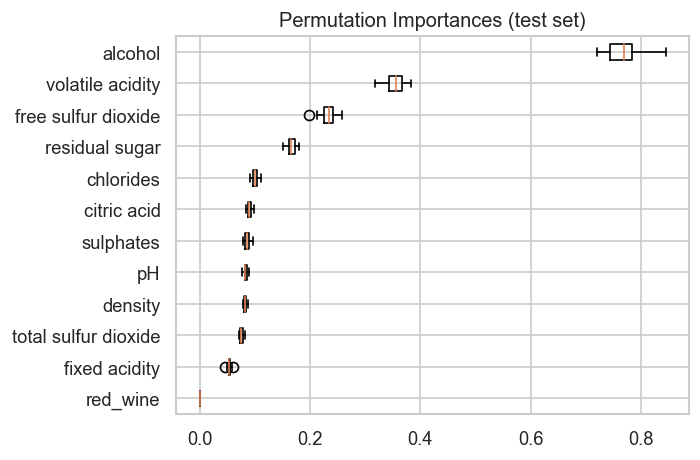

In [22]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(dpi=120)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Adaboost with different base learners

In [12]:
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

dt = DecisionTreeRegressor(min_samples_leaf=10, max_depth=14)
lr = Ridge(normalize=True)
knn = KNeighborsRegressor(n_neighbors=1)

model_labels = ['Decision trees', 'Linear regression', 'KNN']
models = [dt, lr, knn]

for label, model in zip(model_labels, models):
    ada_model = AdaBoostRegressor(model, n_estimators=300, random_state=42)
    score = cross_val_score(ada_model, X_train, y_train,
                            scoring='neg_mean_squared_error', cv=10)
    print(f"Negative mean mse for {label}: {np.mean(score):0.3}")

Negative mean mse for Decision trees: -0.551
Negative mean mse for Linear regression: -0.736
Negative mean mse for KNN: -1.09


## Testing Gradient boosting performance

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbm = GradientBoostingRegressor(n_estimators=300,
                                subsample=0.9, 
                                max_depth=6,
                                min_samples_leaf=10,
                                learning_rate=0.1,
                                random_state=101)
score = cross_val_score(gbm, X_train, y_train, 
                scoring='neg_mean_squared_error', cv=10)

print(f"Negative mean mse for gbm: {np.mean(score):0.3}")

Negative mean mse for gbm: -0.542


## Blending solutions together

In [37]:
from sklearn.ensemble import VotingRegressor

gbm = GradientBoostingRegressor(n_estimators=300,
                                subsample=0.9, 
                                max_depth=6,
                                min_samples_leaf=10,
                                learning_rate=0.1,
                                random_state=101)

rf = RandomForestRegressor(random_state=101)

blender = VotingRegressor(estimators=[('rf', rf), ('gbm', gbm)], n_jobs=-2)
blender.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                                     